In [1]:
import os
import plotly.io as pio

import nltk
import pandas as pd
import plotly.express as px
from nltk.tokenize import word_tokenize
from textract import process
def tokenize_text(text):
    return word_tokenize(text)


# Load the NRC Emotion Lexicon from the text file
def load_lexicon(file_path):
    lexicon_emotion = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            word, emotion, value = line.strip().split('\t')
            if int(value) == 1:
                if word not in lexicon_emotion:
                    lexicon_emotion[word] = set() 
                lexicon_emotion[word].add(emotion)
    return lexicon_emotion

# path to the NRC Emotion Lexicon file
lexicon_file_path = '../data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'

# Load the lexicon
lexicon_emotion = load_lexicon(lexicon_file_path)

def extract_text_textract(pdf_path):
    return process(pdf_path).decode('utf-8')


def perform_sentiment_analysis(text, lexicon_emotion):
    # initialize all to 0
    sentiment_scores = {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'negative': 0, 'positive': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}
    tokens = tokenize_text(text)
    for token in tokens:
        token_emotions = lexicon_emotion.get(token, set())
        for emotion in token_emotions:
            sentiment_scores[emotion] += 1
    return sentiment_scores

def analyze_pdfs_in_directory(directory):
    combined_sentiment_scores = {}
    sentiment_words = {}

    for filename in os.listdir(directory):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(directory, filename)
            text = extract_text_textract(pdf_path)
            sentiment_scores = perform_sentiment_analysis(text, lexicon_emotion)

            # Accumulate sentiment scores
            for sentiment, score in sentiment_scores.items():
                combined_sentiment_scores[sentiment] = combined_sentiment_scores.get(sentiment, 0) + score

            # Collect sentiment words
            for token in word_tokenize(text): 
                if token in lexicon_emotion:
                    token_emotions = lexicon_emotion[token]
                    for emotion in token_emotions:
                        if emotion not in sentiment_words:
                            sentiment_words[emotion] = set()
                        sentiment_words[emotion].add(token)
                        #print(f"Sentiment scores for {filename}: {sentiment_scores}")

    # Print sentiment words
    for sentiment, words in sentiment_words.items():
        print(f"\nWords associated with {sentiment} sentiment:")
        print(words)

    # Convert sentiment dictionary to a DataFrame
    df_sentiment = pd.DataFrame.from_dict(combined_sentiment_scores, orient='index', columns=['Count'])
    df_sentiment.reset_index(inplace=True)
    df_sentiment.rename(columns={'index': 'Sentiment'}, inplace=True)

    # Create a pie chart using Plotly Express
    fig = px.pie(df_sentiment, names='Sentiment', values='Count', hole=0.4, 
                 title='Sentiments Related to Migration',
                 labels={'Count': 'Percentage'},
                 color_discrete_sequence=px.colors.qualitative.Set3)

    
    fig.update_traces(textinfo='percent+label')
    fig.update_layout(template="seaborn", showlegend=False, title_x=0.48, title_y=0.84)
    pio.write_image(fig, '../results/sentimental_disstribution.png',scale=4)
    fig.show()


In [2]:
analyze_pdfs_in_directory('/Users/nischal/Downloads/migration book')



Words associated with positive sentiment:
{'praise', 'main', 'real', 'cater', 'offer', 'improvement', 'horizon', 'academic', 'supported', 'immediately', 'presence', 'experienced', 'productive', 'good', 'fairly', 'agree', 'escape', 'success', 'existence', 'resources', 'beneficial', 'full', 'pool', 'fair', 'advancement', 'task', 'fore', 'trend', 'master', 'prefer', 'labor', 'forthcoming', 'prospect', 'interested', 'president', 'crucial', 'longevity', 'job', 'feature', 'reliable', 'expertise', 'patience', 'communicate', 'pay', 'exceed', 'reason', 'unlimited', 'technology', 'permission', 'facilitate', 'attention', 'considerable', 'represented', 'youth', 'cooperating', 'substantive', 'mayor', 'defense', 'growth', 'inclusive', 'pull', 'destination', 'status', 'journey', 'level', 'balance', 'general', 'established', 'generous', 'ahead', 'professional', 'participation', 'numbers', 'justice', 'retirement', 'promising', 'productivity', 'measured', 'authority', 'revolution', 'elect', 'array', 'h

In [3]:
len(lexicon_emotion)

6453

In [11]:

# word cloud

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import os
from PyPDF2 import PdfReader

def generate_wordcloud_for_pdf_folder(folder_path):
    all_words = ''
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            try:
                reader = PdfReader(file_path)
                for page in reader.pages:
                    all_words += page.extract_text().lower() + ' '
            except Exception as e:
                print(f"Error reading {filename}: {e}")

    # Define a set of common words to exclude from the word cloud
    common_words_to_exclude = {'is', 'the', 'am', 'often', 'figure', 'likely', 'may', 'includes', 'provide', 'providing', 'total', 'source', 'reported', 'higher', 'domain', 'affairs', 'political', 'work', 'policies', 'job', 'persons', 'journal', 'oecd', 'statistical', 'purposes', 'enterprise', 'european', 'refugee', 'report', 'mobility', 'financial', 'contribute', 'sectors', 'age', 'benefit'}
    stopwords = set(STOPWORDS)
    stopwords.update(common_words_to_exclude)

    # Generate a word cloud image excluding common words
    wordcloud = WordCloud(width=1600, height=800, background_color='white', stopwords=stopwords).generate(all_words)

    # Display the generated image:
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    # Save the image in high quality
    plt.savefig('../results/wordcloud_high_quality.png', format='png', dpi=300)
    plt.show()



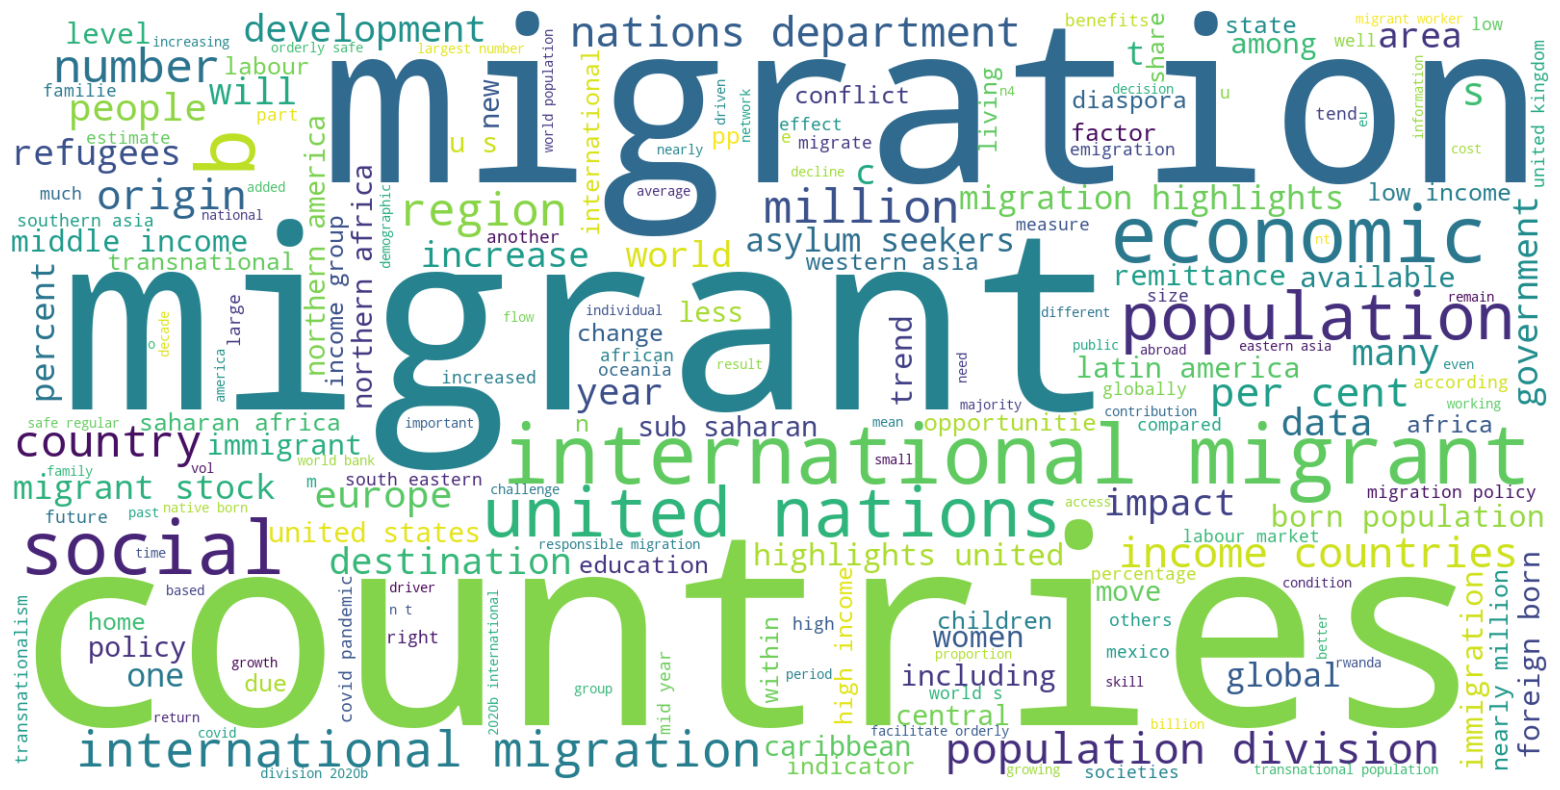

In [12]:
generate_wordcloud_for_pdf_folder('/Users/nischal/Downloads/migration book')